# Please run this code cell by cell and read the comments.

In [34]:
# Libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# Load data
data = pd.read_csv('student_job_fair_data.csv', index_col=0)
# index_col=0 ensures that the first column is used as the index
data

,skills,experience_years,course_grades,projects_completed,extracurriculars,job_offer
student_id,,,,,,
1,Python;Data Analysis;SQL,3,75.26,9,0,1
2,Java,4,74.25,6,2,1
3,Data Analysis,2,74.89,4,3,0
4,Data Analysis,4,72.73,2,3,1
5,Machine Learning;Python;C++,4,84.85,1,4,0
...,...,...,...,...,...,...
19996,Python,1,62.54,1,2,1
19997,Python;Machine Learning,2,84.13,2,2,1
19998,Data Analysis;Java;Machine Learning,1,83.76,7,2,1


In [ ]:
data.info() # There is 1 object columns for skills needs to be encoded

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 1 to 20000
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   skills              20000 non-null  object 
 1   experience_years    20000 non-null  int64  
 2   course_grades       20000 non-null  float64
 3   projects_completed  20000 non-null  int64  
 4   extracurriculars    20000 non-null  int64  
 5   job_offer           20000 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 1.1+ MB


In [ ]:
print("Duplicated values: ",data.duplicated().sum(), 
      "\nMissing values:\n",data.isna().sum())
# No missing values but 2 duplicated

Duplicated values:  2 
Missing values:
 skills                0
experience_years      0
course_grades         0
projects_completed    0
extracurriculars      0
job_offer             0
dtype: int64


In [12]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
data

,skills,experience_years,course_grades,projects_completed,extracurriculars,job_offer
0,Python;Data Analysis;SQL,3,75.26,9,0,1
1,Java,4,74.25,6,2,1
2,Data Analysis,2,74.89,4,3,0
3,Data Analysis,4,72.73,2,3,1
4,Machine Learning;Python;C++,4,84.85,1,4,0
...,...,...,...,...,...,...
19993,Python,1,62.54,1,2,1
19994,Python;Machine Learning,2,84.13,2,2,1
19995,Data Analysis;Java;Machine Learning,1,83.76,7,2,1
19996,SQL;Python,2,60.50,2,3,1


In [14]:
data=shuffle(data, random_state=42).reset_index(drop=True)
data # Shuffle the data to ensure randomness

,skills,experience_years,course_grades,projects_completed,extracurriculars,job_offer
0,Machine Learning;SQL;Python,5,65.67,8,1,0
1,SQL;C++,4,80.58,8,0,0
2,Data Analysis;C++,2,98.23,9,3,1
3,C++;Machine Learning,1,84.92,5,0,1
4,Machine Learning;C++;SQL,2,88.84,7,4,0
...,...,...,...,...,...,...
19993,Java;Data Analysis;SQL,4,88.67,7,2,0
19994,C++;Java,3,61.89,5,4,0
19995,Data Analysis,1,82.14,3,0,0
19996,C++,3,99.46,0,1,1


In [18]:
# Encode the 'skills' column
df = data.copy()
df['skills_list'] = df['skills'].str.split(';')
mlb = MultiLabelBinarizer()
skills_encoded = pd.DataFrame(mlb.fit_transform(df['skills_list']), 
                              columns=mlb.classes_, index=df.index)
df = pd.concat([df.drop(columns=['skills', 'skills_list']), skills_encoded], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   experience_years    19998 non-null  int64  
 1   course_grades       19998 non-null  float64
 2   projects_completed  19998 non-null  int64  
 3   extracurriculars    19998 non-null  int64  
 4   job_offer           19998 non-null  int64  
 5   C++                 19998 non-null  int32  
 6   Data Analysis       19998 non-null  int32  
 7   Java                19998 non-null  int32  
 8   Machine Learning    19998 non-null  int32  
 9   Python              19998 non-null  int32  
 10  SQL                 19998 non-null  int32  
dtypes: float64(1), int32(6), int64(4)
memory usage: 1.2 MB


In [20]:
#Feature Engineering: we will add other features that will affect the target
df['skill_count'] = skills_encoded.sum(axis=1)

In [21]:
df

,experience_years,course_grades,projects_completed,extracurriculars,job_offer,C++,Data Analysis,Java,Machine Learning,Python,SQL,skill_count
0,5,65.67,8,1,0,0,0,0,1,1,1,3
1,4,80.58,8,0,0,1,0,0,0,0,1,2
2,2,98.23,9,3,1,1,1,0,0,0,0,2
3,1,84.92,5,0,1,1,0,0,1,0,0,2
4,2,88.84,7,4,0,1,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
19993,4,88.67,7,2,0,0,1,1,0,0,1,3
19994,3,61.89,5,4,0,1,0,1,0,0,0,2
19995,1,82.14,3,0,0,0,1,0,0,0,0,1
19996,3,99.46,0,1,1,1,0,0,0,0,0,1


In [ ]:
# Check imbalanced classes
counts = Counter(df['job_offer'])
majority_class = max(counts, key=counts.get)
minority_class = min(counts, key=counts.get)
imbalance_ratio = counts[majority_class] / counts[minority_class]
print(f"Imbalance Ratio: {imbalance_ratio:.2f} (Majority: {majority_class}, Minority: {minority_class})")
# Imbalance ratio < 1.5 indicates a balanced dataset (no sampling needed)

Imbalance Ratio: 1.03 (Majority: 0, Minority: 1)


In [25]:
#Train-test split
features = df.drop(columns=['job_offer'])
target = df['job_offer']
# stratify the split to maintain the class distribution
xtrain, xtest, ytrain, ytest = train_test_split(features, target, stratify=target, test_size=0.2, random_state=42)
# Train using XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(xtrain, ytrain)

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:19:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
ypred = model.predict(xtest)
print("Accuracy:", accuracy_score(ytest, ypred))
#print("ROC-AUC:", model.score(xtest, ytest))
print("Confusion Matrix:\n", confusion_matrix(ytest, ypred))
print("Classification Report:\n", classification_report(ytest, ypred))

Accuracy: 0.4965
ROC-AUC: 0.4965
Confusion Matrix:
 [[1029  996]
 [1018  957]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51      2025
           1       0.49      0.48      0.49      1975

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000



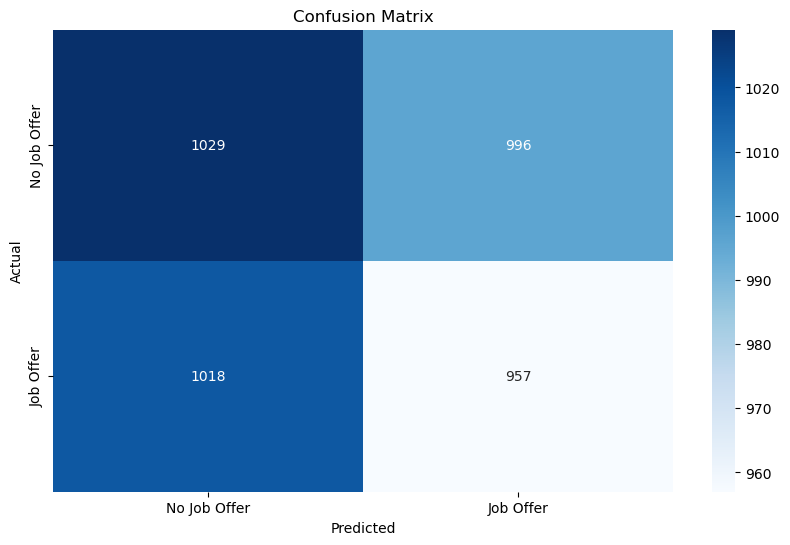

In [33]:
# Confusion matrix visualization
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(ytest, ypred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Job Offer', 'Job Offer'], yticklabels=['No Job Offer', 'Job Offer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_37032\2239277249.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=imbortance_df, palette='viridis')


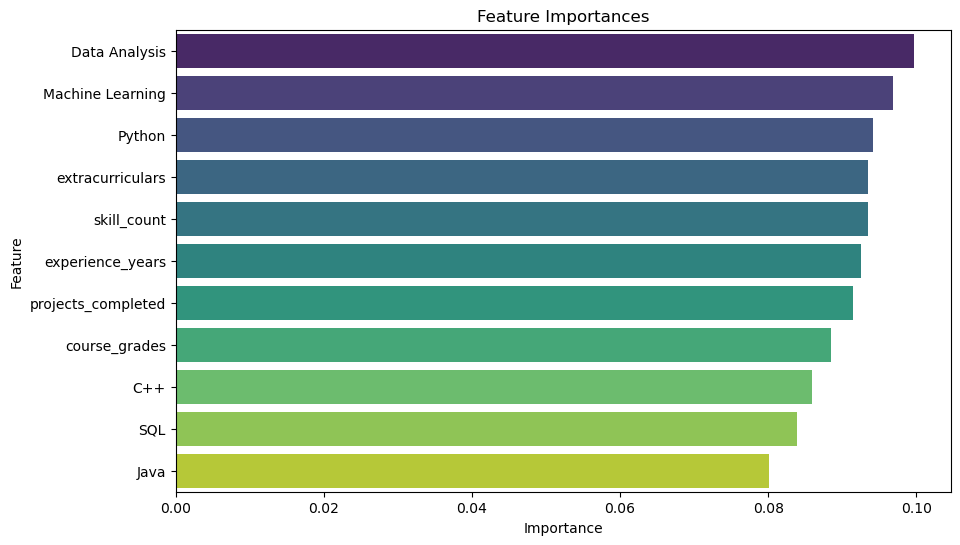

In [29]:
# Feature Importance
importances = model.feature_importances_
feature_names = features.columns
imbortance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imbortance_df = imbortance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=imbortance_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [30]:
# Cross-validation
scores = cross_val_score(model, features, target, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")

C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [15:33:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

Cross-validation scores: [0.493      0.49225    0.5025     0.49687422 0.48537134]


Train Accuracy: 0.78, Test Accuracy: 0.50


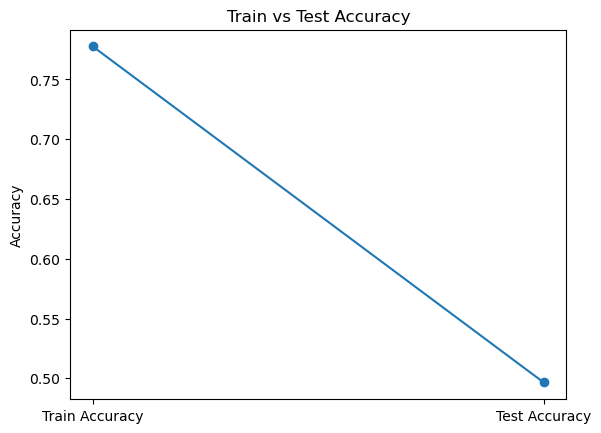

In [32]:
# Recheck overfitting and underfitting
train_pred = model.predict(xtrain)
train_accuracy = accuracy_score(ytrain, train_pred)
test_pred = model.predict(xtest)
test_accuracy = accuracy_score(ytest, test_pred)
print(f"Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_accuracy:.2f}")
plt.plot([1, 2], [train_accuracy, test_accuracy], marker='o')
plt.xticks([1, 2], ['Train Accuracy', 'Test Accuracy'])
plt.title('Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.show()

# Plot showed that diffrence between train and test accuracy is significant, 
# indicating overfitting.